# Thesis: lifetime analysis 
works with assumption B and C, for NE Midtbyen

for assumption A, other code

## Imports

In [43]:
#imports

import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

from scipy.optimize import curve_fit

from scipy import integrate

import random

#from lifelines import KaplanMeierFitter

from scipy.stats import weibull_min
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import truncnorm

from scipy.interpolate import splrep, BSpline


## CHOICE OF HYPOTHESIS AND STUDY AREA

hypothesis b: we use the cohort of survivor buildings to estimate the missing data

hypothesis c: we use the cohort of survivor buildings to estimate the missing data AND we assume that the buildings were rebuilt in max 10 yrs after the fire

Study area: 'Midtbyen' = NE Midtbyen or 'Skansen'
 

In [44]:
hypothesis = 'c'
area = 'Midtbyen'

## Constants

In [45]:
# Constants
#depending on the area, diff dates
if area == 'Midtbyen':
    debut_date = 1841
    end_date = 1845
else:
    debut_date = 1842
    end_date = 1846
present_date = 2022
map_date = 1883
prot_date = 1981
assumed_cohort = 1843

# Histogram range bins
range_bins = [1838 + 2*i for i in range(25)]

# Time steps and range
time_steps = np.arange(debut_date, present_date)
x_range = np.linspace(0, 1000000, 1000001)


# Age steps
age_steps = np.arange(0, present_date - debut_date)

# Fit curve range
x_time = np.linspace(1835, 1890,100)


## Extracting data from the ArcGIS attribute tables

Define the path to the table, it had to have been saved as a .csv file in ArcGIS.

(To save as a .csv file in ArcGIS : Open attribute table >> export >> chose the folder and save as name.csv)

### Functions

In [46]:
# to choose which hypothesis you want to perform (does not work for uniform)
# YOU HAVE TO CHANGE THE BEGINNING OF THE FILE PATHS TO CORRESPOND TO YOUR OWN
def choice_hypothesis_area(hypothesis,area):
    # area NE Midtbyen
    if area == 'Midtbyen':
        if hypothesis == 'b':
        # hypothesis b: we use the cohort of survivor buildings to estimate the missing data
            file_path_demolished = r"C:\Users\zoec\OneDrive - NTNU\Thesis_NTNU\Datafram_tables\v1_13_02\demolished.csv"
            file_path_standing = r"C:\Users\zoec\OneDrive - NTNU\Thesis_NTNU\Datafram_tables\v1_13_02\still_standing.csv"
            file_path_no_data = r"C:\Users\zoec\OneDrive - NTNU\Thesis_NTNU\Datafram_tables\v1_13_02\no_date_match.csv" 
        elif hypothesis == 'c':
        # hypothesis c: we use the cohort of survivor buildings to estimate the missing data 
        # AND we assume that the buildings were rebuilt in max 10 yrs after the fire
            file_path_demolished = r"C:\Users\zoec\OneDrive - NTNU\Thesis_NTNU\Datafram_tables\v2_14_03\demolished.csv"
            file_path_standing = r"C:\Users\zoec\OneDrive - NTNU\Thesis_NTNU\Datafram_tables\v2_14_03\still_standing.csv"
            file_path_no_data = r"C:\Users\zoec\OneDrive - NTNU\Thesis_NTNU\Datafram_tables\v2_14_03\no_date_match.csv"
        else:
            print("Invalid hypothesis choice. Please select 'b' or 'c'.")
        return [file_path_demolished, file_path_standing, file_path_no_data]
    elif area=='Skansen':
        if hypothesis == 'b':
        # hypothesis b: we use the cohort of survivor buildings to estimate the missing data
            file_path_demolished = r"C:\Users\zoec\OneDrive - NTNU\Thesis_NTNU\Datafram_tables\v5_20_04_Skansen\Skansen_demolished.csv"
            file_path_standing = r"C:\Users\zoec\OneDrive - NTNU\Thesis_NTNU\Datafram_tables\v5_20_04_Skansen\Skansen_still_standing.csv"
        elif hypothesis == 'c':
        # hypothesis c: we use the cohort of survivor buildings to estimate the missing data 
        # AND we assume that the buildings were rebuilt in max 10 yrs after the fire
            file_path_demolished = r"C:\Users\zoec\OneDrive - NTNU\Thesis_NTNU\Datafram_tables\v6_02_05_Skansen\Skansen_demolished.csv"
            file_path_standing = r"C:\Users\zoec\OneDrive - NTNU\Thesis_NTNU\Datafram_tables\v6_02_05_Skansen\Skansen_still_standing.csv"
        else:
            print("Invalid hypothesis choice. Please select 'b' or 'c'.")
        return [file_path_demolished, file_path_standing]
    else:
        print("Invalid hypothesis choice. Please select 'Midtbyen' or 'Skansen'.")

"""-----------------------------------------------------------------------"""
# function to read the file as a pandas dataframe and fill the NaN cells with 0

def read_file_csv(file):
    df = pd.read_csv(file, sep = ";")
    return df

#returns a dataframe

"""-----------------------------------------------------------------------"""


'-----------------------------------------------------------------------'

### Code

#### Extracting the data exported from ArcGIS (three dataframes : one for the demolished buildings and one for the still standing + one for no data)

The names are misleading: some buildings in the file "demolished" are still standing and vice versa. Proper df are made later

In [47]:
# Get file paths based on hypothesis + area choice
# Read the files into pandas dataframes
if area=='Midtbyen':
    file_path_demolished, file_path_standing, file_path_no_data = choice_hypothesis_area(hypothesis,area)
    df_demolished = read_file_csv(file_path_demolished)
    df_standing = read_file_csv(file_path_standing)
    df_nodata = read_file_csv(file_path_no_data)
    # Concatenate the dataframes
    df_full = pd.concat([df_demolished, df_standing, df_nodata], ignore_index=True)
else :#area=='Skansen':
    file_path_demolished, file_path_standing = choice_hypothesis_area(hypothesis,area)
    df_demolished = read_file_csv(file_path_demolished)
    df_standing = read_file_csv(file_path_standing)
    # Concatenate the dataframes
    df_full = pd.concat([df_demolished, df_standing], ignore_index=True)


# Replace missing values in 'Is_demolished' column with -1
df_full['Is_demolished'] = df_full['Is_demolished'].fillna(-1)

# Fill NaN values with 0
df_full = df_full.fillna(0)

# drop those that are out of range == built before the fire (because we assume that apart from those, no buildings survived the fire)

df_full = df_full.drop(df_full[(df_full['Construction_max']< debut_date )].index)

## Dealing with "no data" buildings (only for Skansen)

In [48]:
# Visualizing the number of buildings without data: ZERO for NE Midtbyen

df_no_data = df_full[(df_full['Is_demolished'] ==-1)]

display(df_no_data)
# randomly assigning a status (demolished Y/N) and a demolition date for the ones w/o data
def attribute_dem_for_nodata(df, map_date, present_date):
    # Randomly assign true or false values to the 'Is_demolished' column
    df_no_data = df[df['Is_demolished'] == -1]
    indices = df_no_data.index

    df.loc[indices, 'Is_demolished'] = [random.choice([True, False]) for _ in range(len(df_no_data))]
    
    # Assign random values between map_date and present_date to 'Demolition_min' column for rows where 'Is_demolished' is True
    
    df.loc[indices, 'Demolition_min'] = [random.randint(map_date, present_date) for _ in range(len(indices))]
    
    # Set 'Demolition_max' equal to 'Demolition_min'
    df.loc[indices, 'Demolition_max'] = df.loc[indices, 'Demolition_min']
    
    df.fillna(0)

Empty DataFrame
Columns: [OID_, X, Y, Shape_Length, Shape_Area, Construction_min, Construction_max, Demolition_min, Demolition_max, Address, Cause, Source, Comments, Is_demolished, Fire]
Index: []

In [49]:
attribute_dem_for_nodata(df_full,map_date,present_date)

## Attributing a demolition date between D_min and D_max

### Functions

In [50]:
def attribute_d_unif(df):
    # If no data for min demolition date, take the max (usually the construction date of the new building) - 10 years
    df['Demolition_min'] = np.where(df['Demolition_min'] == 0, df['Demolition_max'] - 10, df['Demolition_min'])
    
    # Generate a uniform random demolition date between the min and max values
    df['D_unif'] = np.random.uniform(df['Demolition_min'], df['Demolition_max'])
    df['D_unif'] = np.trunc(df['D_unif']).astype(int)
    
    return df


### Code

In [51]:
# attributing the demolition date
df_full = attribute_d_unif(df_full)

# print it to check it
#display(df_full)

## Fitting a lognormal distribution to the buildings still standing

Using the cohorts of the still standing buildings, we fit a lognormal distribution. This distribution will then be used to assign a construction date to the buildings that currently only have an interval as a construction date. 

### Functions

In [52]:
# attributing a construction date for the buildings still standing randomly between min and max
# takes in input the full dataframe
# returns a df of still standing buildings

def attribute_c_unif(df):
    # Create a copy of the DataFrame for buildings that are still standing
    df_res = df[df['Is_demolished'] == False].copy()
    
    # Generate a uniform random construction date between the min and max values
    df_res['C_unif'] = np.random.uniform(df_res['Construction_min'], df_res['Construction_max'])
    df_res['C_unif'] = np.trunc(df_res['C_unif']).astype(int)
    
    return df_res

"""---------------------------------------------------------------------------------"""
# lognormal survival function : for curve fitting

def lognorm_sf(x, s, loc, scale):
    return lognorm.sf(x, s, loc, scale)

"""---------------------------------------------------------------------------------"""
# find best fit of construction date data (with lognormal fct)
# returns the parameters of the fit

def fit_cohort(df):
    return lognorm.fit(df['C_unif'])

"""---------------------------------------------------------------------------------"""
# find best fit of data, works for any type of fct (not only lognormal)

def fit_surv_fct(s_fct, x, y):
# Fit the data to the lognormal function using curve_fit
    p_surv_fct, p_sf_cov = curve_fit(s_fct, x, y)
    return(p_surv_fct)

### Code

In [53]:
# make a df of still standing buildings (that were built after the fire)

df_still_standing = attribute_c_unif(df_full)

# print dataframe of the buildings still standing
#display(df_still_standing)

# fit the histogram of the construction date using a lognormal function
params_logn = fit_cohort(df_still_standing)

In [54]:
# find out best fit parameters
params_logn = fit_cohort(df_still_standing)

### Plot

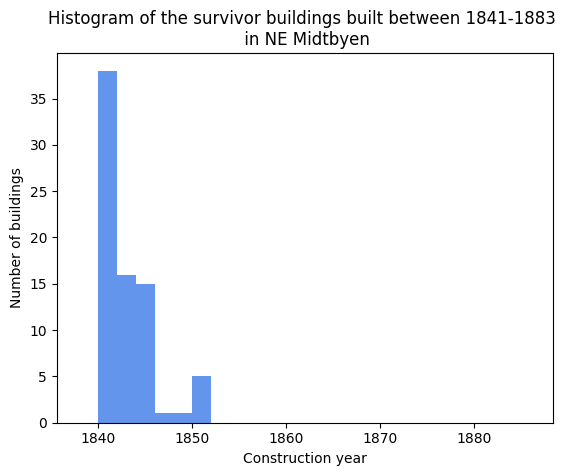

In [55]:
# plot a histogram of the survivor buildings (in 2022)

plt.hist(df_still_standing['C_unif'], bins = range_bins, color='cornflowerblue')
plt.xlabel('Construction year')
plt.ylabel('Number of buildings')
plt.title('Histogram of the survivor buildings built between 1841-1883 \n in NE Midtbyen')

plt.show()

25
(15.054074454545225, 1840.9999999999998, 7.768273922296628e-07)


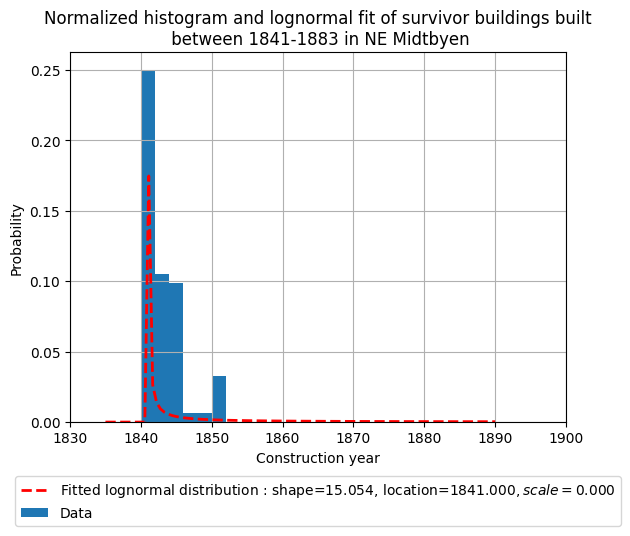

In [56]:
# fit the cohort of still standing buildings

#if midtbyen: use lognorm
# if skansen: weibull works better
params_logn = lognorm.fit(df_still_standing['C_unif'])
n, bins, patches = plt.hist( df_still_standing['C_unif'],bins= range_bins, density=True)
print(len(range_bins))
# add a 'best fit' line
y = lognorm.pdf(x_time, *params_logn)

print(params_logn)
shape = params_logn[0] # shape parameter
loc = params_logn[1] # mean(ln(Y))
scale = params_logn[2] # sd(ln(Y))"""

labels = ['Fitted lognormal distribution : shape=%.3f, location=%.3f$, scale=%.3f$' %(shape,loc,scale),'Data']

plt.plot(x_time , y, 'r--', linewidth=2)
plt.xlabel('Construction year')
plt.ylabel('Probability')
plt.title('Normalized histogram and lognormal fit of survivor buildings built\n between 1841-1883 in NE Midtbyen')
plt.grid(True)
plt.xlim(1830,1900)
plt.legend(labels=labels, loc = 'lower center', bbox_to_anchor=(0.5, -0.3))
#plt.show()

## Attributing a construction date according to the lognormal distribution
To do so, I will create two new columns in the DataFrame : C_unif and D_unif

### Functions

In [57]:
#for the construction date : attribute a value according to the distribution and the interval C_min,C_max
def value_construction(C_min, C_max,params_logn):
    if C_max != C_min:
        rd_lognorm = lognorm.rvs(*params_logn, 1)[0]
        while rd_lognorm > C_max or rd_lognorm < C_min:
            rd_lognorm = lognorm.rvs(*params_logn, 1)[0]
        C_lognorm = int(np.trunc(rd_lognorm))
    else:
        C_lognorm = C_min
    return C_lognorm

#returns one value

"""---------------------------------------------------------------------------------"""
def attribute_c_lognorm(df, params_logn):
    # Generate random variables for construction and demolition dates
    for row in df.iterrows():
        C_max = row[1]['Construction_max']
        C_min = row[1]['Construction_min']
        row[1]['C_lognorm'] = value_construction(C_min, C_max,params_logn)

# doesn't return anything but changes the df



### Code

In [58]:
# creating a working dataframe with only the required data
df_full['C_lognorm'] = 0
df_working = df_full[['Construction_min','Construction_max','C_lognorm']].copy()

# attributing a construction date according to the lognormal fit

attribute_c_lognorm(df_working,params_logn)

# assigning it in the full dataframe as well

df_full['C_lognorm'] = df_working['C_lognorm']

### Plot

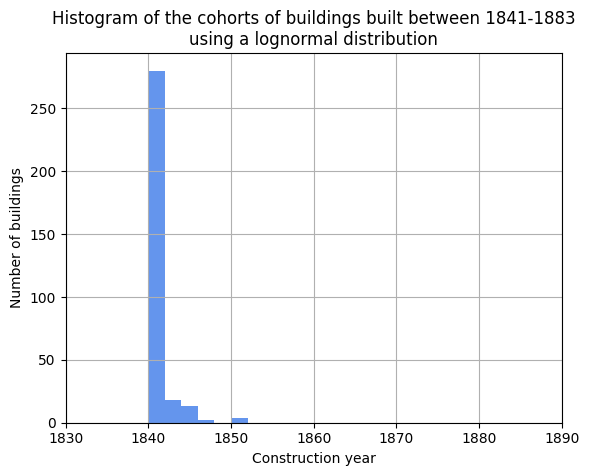

In [59]:
# plotting the histogram of cohort of all buildings (dem + non dem) after attributing construction date using lognormal distribution


plt.hist(df_working['C_lognorm'], bins = range_bins, color ='cornflowerblue')
plt.xlabel('Construction year')
plt.ylabel('Number of buildings')
plt.title('Histogram of the cohorts of buildings built between 1841-1883\nusing a lognormal distribution')
plt.grid(True)
plt.xlim(1830,1890)
plt.show()

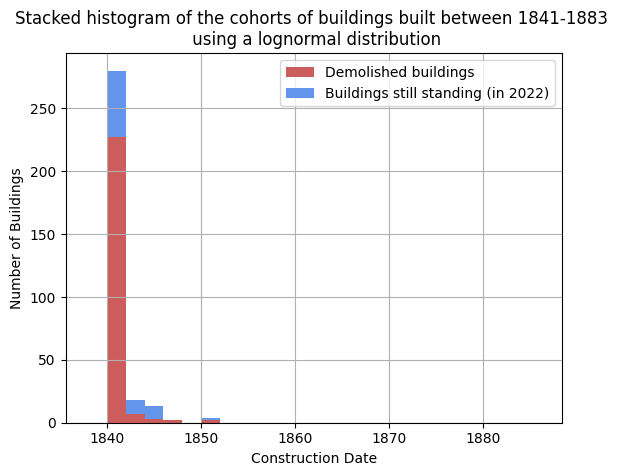

In [60]:
# Differentiating dem and non dem buildings in  a STACKED HISTOGRAM

# Filter demolished buildings
demolished_df = df_full[df_full['Is_demolished'] == True]

# Filter standing buildings
standing_df = df_full[df_full['Is_demolished'] == False]

# Create a histogram of the construction dates for demolished buildings
plt.hist([demolished_df['C_lognorm'], standing_df['C_lognorm']], bins = range_bins, label=['Demolished buildings','Buildings still standing (in 2022)'], color = ['indianred','cornflowerblue'],stacked=True)
plt.grid()
# Create a histogram of the construction dates for standing buildings, stacked on top of the demolished buildings histogram
#plt.hist(standing_df['C_lognorm'], bins = range_bins, label='Standing (in 2022)', color='cornflowerblue',stacke)

# Add labels and title to the plot
plt.xlabel('Construction Date')
plt.ylabel('Number of Buildings')
plt.title('Stacked histogram of the cohorts of buildings built between 1841-1883 \n using a lognormal distribution')

# Add a legend
plt.legend()

# Show the plot

[   0 -227   -7   -3   -2    0   -2    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0] [1838 1840 1842 1844 1846 1848 1850 1852 1854 1856 1858 1860 1862 1864
 1866 1868 1870 1872 1874 1876 1878 1880 1882 1884 1886]


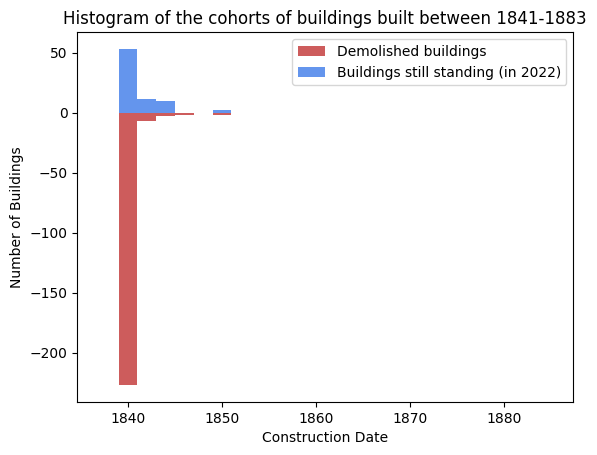

In [61]:
# Differentiating dem and non dem buildings in  a POSITIVE/NEGATIVE HISTOGRAM
negative_data = demolished_df['C_lognorm']
positive_data = standing_df['C_lognorm']
tot_1 = len(negative_data)
tot_2=len(positive_data)
a, b = np.histogram(demolished_df['C_lognorm'],bins=range_bins)
c ,d = np.histogram(standing_df['C_lognorm'],bins=range_bins)
print(-a,b)
fig = plt.figure()
ax = plt.subplot(111)

plt.bar(b[:-1],height=-a,width=np.diff(b), label = 'Demolished buildings', color = 'indianred')
plt.bar(d[:-1],height=c,width=np.diff(d), label = 'Buildings still standing (in 2022)', color = 'cornflowerblue')

plt.xlabel('Construction Date')
plt.ylabel('Number of Buildings')
plt.title('Histogram of the cohorts of buildings built between 1841-1883')

plt.legend()


## Obtaining the Survival function

### Functions

In [62]:
# to obtain the failure time (=> age at demolition)

def failure_time(dem_df,df):
    # Compute the failure time for each demolished building
    age_at_demolition = dem_df['D_unif'] - dem_df['C_lognorm'] 
    # if not demolished: attribute 0, else attribute failure time
    df['Age_at_demolition'] = np.where(df['Is_demolished']==True,df['D_unif']-df['C_lognorm'],0)

# doesnt return anything but changes the df

"""---------------------------------------------------------------------------------"""

#selecting the cohorts of interest ie construction date llies between min and max
def selected_cohorts(df,yr_min,yr_max):
    df_selected_cohort = df[(df['C_lognorm'] >= yr_min) & (df['C_lognorm'] <= yr_max)]
    return df_selected_cohort

#returns a df of the selected cohorts

"""---------------------------------------------------------------------------------"""
#Calculate the points of the survival curve USING AGE

def survival_curve(age, df):
    survival_prob = np.ones(len(age))
    n_total = len(df)
    n_alive = np.sum(df['Is_demolished'] == False)
    for t in (age):
        if t == 0:
            survival_prob[t] = 1

        else: 
            n_survived = np.sum((df['Age_at_demolition'] >= t)) + n_alive
            surv_ratio = n_survived/n_total
            survival_prob[t] = survival_prob[t]*surv_ratio
    return survival_prob

#returns a list (or array ?) of the points of the survival curve 

### Code

In [63]:
# creating a new column in the df to show the age at dmeolition = failure time
failure_time(demolished_df, df_full)

# select the cohorts of interest : here btw 1840-1845
df_1841_1845 = selected_cohorts(df_full, debut_date, end_date)

# NOT NECESSARY BUT BETTER FOR VISUALISATION: assign the same construction date for all buildings in the selected cohorts. That way,
# you can visualize events like fires better

df_1841_1845 = df_1841_1845.assign(C_lognorm = assumed_cohort)

# calculate the survival probabillity according to age on this cohort
survival_prob = survival_curve(age_steps,df_1841_1845)

### Plot

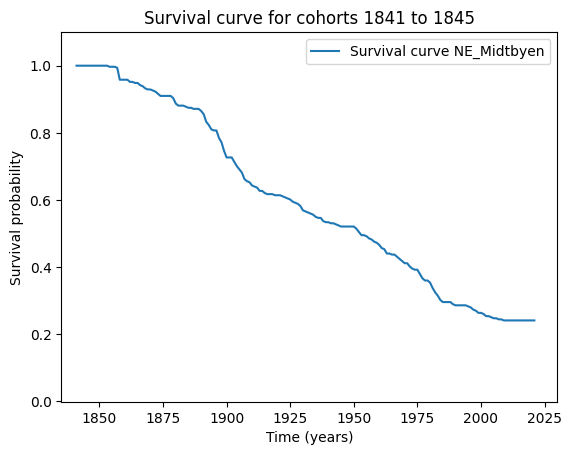

In [64]:
# for cohorts 1841-1845 = estimated as cohort 1843
  
plt.plot(age_steps + debut_date ,survival_prob)
plt.ylim(0,1.1)
plt.xlabel('Time (years)')
plt.ylabel('Survival probability')
plt.title('Survival curve for cohorts 1841 to 1845')
plt.xlim(1835,2030)
plt.ylim(-0.001,1.1)

#labels=['Survival curve NE_Midtbyen']
labels=['Survival curve NE_Midtbyen']
plt.legend(labels=labels)
plt.show()


In [65]:
i_1981=1981-debut_date
s_before_1981 = survival_prob[0:i_1981]



#### unnecessary step

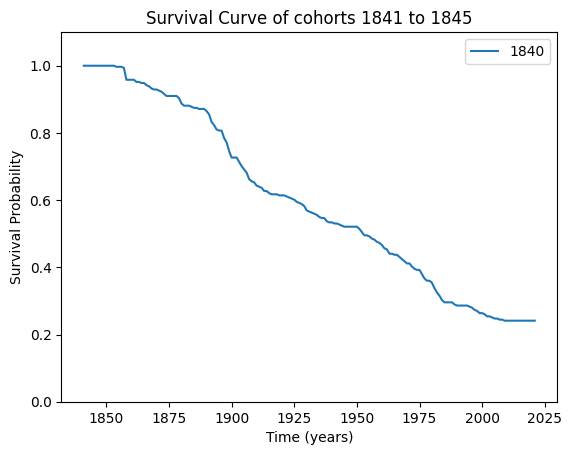

In [66]:
# for individual cohorts (unnecessary now)

cohorts = df_1841_1845["C_lognorm"].unique()
labels = ['1840','1841','1842','1843','1844','1845']
for cohort in cohorts:
    df_cohort = df_1841_1845[df_1841_1845['C_lognorm']==cohort]
    #display(df_cohort)
    survival_prob_cohort = survival_curve(age_steps,df_cohort)
    #print(survival_prob)
    plt.plot(time_steps,survival_prob_cohort)
    plt.legend(labels)
#plt.plot(time_steps, survival_prob)
    plt.title("Survival Curve of cohorts 1841 to 1845")
    plt.xlabel("Time (years)")
    plt.ylabel("Survival Probability")
    plt.ylim(0,1.1)
#plt.show()

## Fitting the survival curve and obtaining lifetime

In [67]:
# making a df of all non demolished buildings
df_trace_age = df_full[df_full['Age_at_demolition']>0]

# Constants
x_1 = age_steps[0:i_1981]
y_1 = s_before_1981

x = age_steps
y = survival_prob

### Functions

In [68]:
# Define the Weibull distribution function : use scipy fct directly (offset parameter)
def weibull(x, a, k):
    #return weibull_min.sf(x, c, loc, scale)
    return np.exp(-(x*a)**k) 
"""---------------------------------------------------------------------------------"""
# define normal survival function

def norm_sf(x, loc, scale):
    return norm.sf(x, loc, scale)
"""---------------------------------------------------------------------------------"""
# define lognorm survival function

def lognorm_sf(x, s, loc, scale):
    return lognorm.sf(x, s, loc, scale)

"""---------------------------------------------------------------------------------"""
# def the lifetime functions = pdf

def lifetime_weibull(x, a, k):
    return a*k*(a*x)**(k-1)*np.exp(-(x*a)**k)

def lifetime_norm(x, loc, scale):
    return norm.pdf(x, loc, scale)

def lifetime_lognorm(x, s, loc, scale):
    return lognorm.pdf(x, s, loc, scale)

"""---------------------------------------------------------------------------------"""
# define function to obtain R² value = estimate goodness of fit
def calculate_r_squared(actual_values, predicted_values):
    mean_actual = sum(actual_values) / len(actual_values)
    total_sum_of_squares = sum((actual - mean_actual) ** 2 for actual in actual_values)
    residual_sum_of_squares = sum((actual - predicted) ** 2 for actual, predicted in zip(actual_values, predicted_values))
    r_squared = 1 - (residual_sum_of_squares / total_sum_of_squares)
    return r_squared

### Code

In [69]:
# Fit the data to the Weibull function using curve_fit
p_weib, p_weib_cov = curve_fit(weibull, x, y)

# Print the fitted parameters
print(p_weib)

# calculate R²
r_weibull = calculate_r_squared(y,weibull(x,*p_weib))
print('R²_weibull =', r_weibull)

[0.00742787 1.55209839]
R²_weibull = 0.9902899787880406


C:\Users\zoec\AppData\Local\Temp\ipykernel_19520\631340517.py:4: RuntimeWarning: divide by zero encountered in power
  return np.exp(-(x*a)**k)
C:\Users\zoec\AppData\Local\Temp\ipykernel_19520\631340517.py:4: RuntimeWarning: invalid value encountered in power
  return np.exp(-(x*a)**k)


In [70]:
# Fit the data to the normal function using curve_fit
p_norm, p_norm_cov = curve_fit(norm_sf, x, y)

# Print the fitted parameters
print('mu =', p_norm[0])
print('sigma =', p_norm[1])

r_norm = calculate_r_squared(y,norm_sf(x,*p_norm))
print('R²_normal =', r_norm)

mu = 111.08181091720438
sigma = 70.03503557517745
R²_normal = 0.9688311170270938


In [71]:
# Fit the data to the lognormal function using curve_fit
p_logn, p_logn_cov = curve_fit(lognorm_sf, x, y)

# Print the fitted parameters
print('param =', p_logn)

r_lognorm = calculate_r_squared(y,lognorm_sf(x,*p_logn))
print('R²_lognorm =',r_lognorm)

param = [  0.67337695 -14.60876036 118.31106654]
R²_lognorm = 0.9912008128136237


In [75]:
# Define the truncated normal survival function
def truncnorm_sf(x, a, b, loc, scale):
    return truncnorm.sf(x, a, b, loc, scale)

data = y


p_trunc, p_trunc_cov = curve_fit(truncnorm_sf, x, y)

c:\Users\zoec\OneDrive - NTNU\Thesis_NTNU\VSC_lifetime\.venv\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [74]:
print(p_trunc)

[1. 1. 1. 1.]


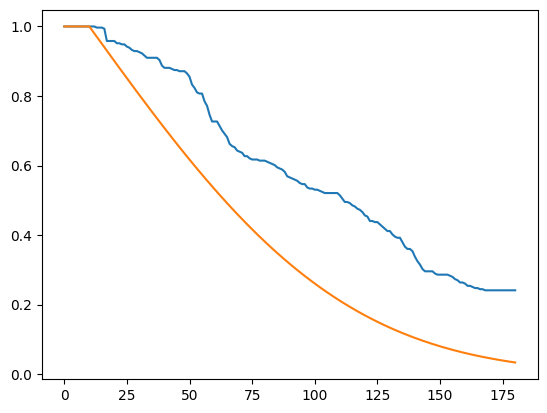

In [93]:
plt.plot(x,y)
plt.plot(x, truncnorm_sf(x,0,100,10,80))

### Plot

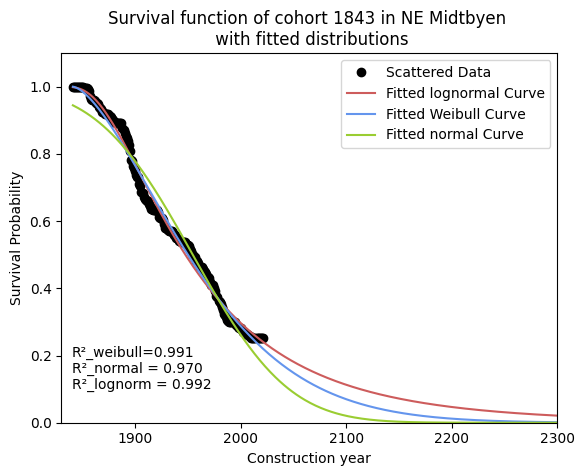

In [30]:
#Trace survival curves with each fit

plt.plot(x+debut_date, y, 'ko', label='Scattered Data')
plt.plot(x_range+debut_date, lognorm_sf(x_range, *p_logn),'indianred', label='Fitted lognormal Curve')
plt.plot(x_range+debut_date, weibull(x_range, *p_weib), 'cornflowerblue', label='Fitted Weibull Curve')
plt.plot(x_range+debut_date, norm_sf(x_range, *p_norm),'yellowgreen', label='Fitted normal Curve')
plt.ylim(0,1.1)
plt.xlabel('Construction year')
plt.ylabel('Survival Probability')
plt.legend()

plt.annotate('R²_weibull=%.3f\nR²_normal = %.3f\nR²_lognorm = %.3f' %(r_weibull,r_norm,r_lognorm), (1840, 0.1))
plt.title('Survival function of cohort 1843 in NE Midtbyen \n with fitted distributions')
plt.xlim(1830,2300)
plt.show()


In [31]:
# Constants

s_after_1981 = survival_prob[i_1981:]
x_2 = age_steps[i_1981:]

y_2 = s_after_1981

# Fit the data to the lognormal function using curve_fit
p_logn_2, p_logn_cov_2 = curve_fit(lognorm_sf, x_2, y_2)
p_logn_1, p_logn_cov_1 = curve_fit(lognorm_sf, x_1, y_1)
# Print the fitted parameters
print('param =', p_logn_2)
"""
plt.plot(x+debut_date, y, 'ko', label='Scattered Data')
plt.plot(x_range+debut_date, lognorm_sf(x_range, *p_logn_1),'red', label='Fitted lognormal Curve')
plt.plot(x_range+debut_date, lognorm_sf(x_range, *p_logn_2),'indianred', label='Fitted lognormal Curve')
plt.xlim(1830,2300)"""

param = [  6.96228098 134.12524178   0.3993437 ]


"\nplt.plot(x+debut_date, y, 'ko', label='Scattered Data')\nplt.plot(x_range+debut_date, lognorm_sf(x_range, *p_logn_1),'red', label='Fitted lognormal Curve')\nplt.plot(x_range+debut_date, lognorm_sf(x_range, *p_logn_2),'indianred', label='Fitted lognormal Curve')\nplt.xlim(1830,2300)"

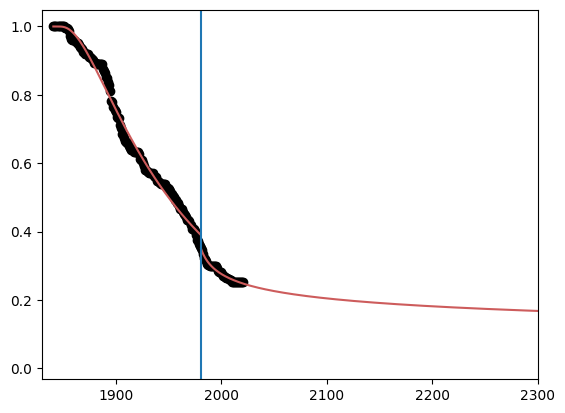

In [32]:

plt.plot(x+debut_date, y, 'ko', label='Scattered Data')
plt.plot(x_range[0:i_1981]+debut_date, lognorm_sf(x_range[0:i_1981], *p_logn_1),'indianred', label='Fitted lognormal Curve')
plt.plot(x_range[i_1981:]+debut_date, lognorm_sf(x_range[i_1981:], *p_logn_2),'indianred', label='Fitted lognormal Curve')
plt.xlim(1830,2300)
plt.axvline(1981)

In [33]:
#smooth it with a spline

x_range_array = np.array(x_range)

# Calculate two_lognorm values
two_lognorm_1 = lognorm_sf(x_range_array[x_range_array < i_1981], *p_logn_1)
two_lognorm_2 = lognorm_sf(x_range_array[x_range_array >= i_1981], *p_logn_2)

two_lognorm = np.concatenate((two_lognorm_1, two_lognorm_2))
"""
two_lognorm = []

for i in (x_range[0:i_1981]):
    two_lognorm.append(lognorm_sf(i, *p_logn_1))
for j in (x_range[i_1981:]):
    two_lognorm.append(lognorm_sf(j, *p_logn_2))"""

'\ntwo_lognorm = []\n\nfor i in (x_range[0:i_1981]):\n    two_lognorm.append(lognorm_sf(i, *p_logn_1))\nfor j in (x_range[i_1981:]):\n    two_lognorm.append(lognorm_sf(j, *p_logn_2))'

In [34]:
from scipy.interpolate import UnivariateSpline

better_fit_x = np.linspace(-10000,-1,10000)
better_fit_y = np.ones(10000)

x_range_spline = np.concatenate((better_fit_x, x_range))
y_range_spline = np.concatenate((better_fit_y, two_lognorm))
spline = UnivariateSpline(x_range_spline,y_range_spline, s=0.025)

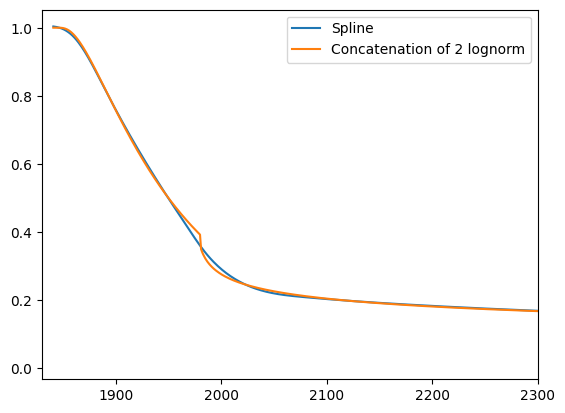

In [35]:
plt.plot(x_range+debut_date, spline(x_range))
plt.plot(x_range+debut_date,two_lognorm)

plt.xlim(1830,2300)

label = ['Spline', 'Concatenation of 2 lognorm']
plt.legend(label)

In [36]:
# Calculate the differences between consecutive survival probabilities
diff_survival_probabilities = np.diff(spline(x_range_spline))

# Calculate the derivative of the lifetime distribution
lifetime_distribution_derivative = -diff_survival_probabilities / np.diff(x_range_spline)
"""
plt.plot(x_range_spline[:len(x_range_spline)-1]+debut_date,lifetime_distribution_derivative)
plt.xlim(1830,2300)
plt.ylim(0,0.007)
"""

'\nplt.plot(x_range_spline[:len(x_range_spline)-1]+debut_date,lifetime_distribution_derivative)\nplt.xlim(1830,2300)\nplt.ylim(0,0.007)\n'

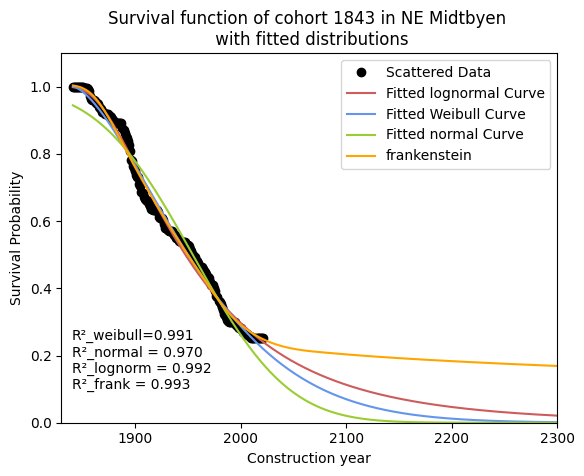

In [37]:
#Trace survival curves with each fit


plt.plot(x+debut_date, y, 'ko', label='Scattered Data')
plt.plot(x_range+debut_date, lognorm_sf(x_range, *p_logn),'indianred', label='Fitted lognormal Curve')
plt.plot(x_range+debut_date, weibull(x_range, *p_weib), 'cornflowerblue', label='Fitted Weibull Curve')
plt.plot(x_range+debut_date, norm_sf(x_range, *p_norm),'yellowgreen', label='Fitted normal Curve')
plt.plot(x_range+debut_date, spline(x_range),'orange',label='frankenstein')

r_frank = calculate_r_squared(y,spline(x))

plt.ylim(0,1.1)
plt.xlabel('Construction year')
plt.ylabel('Survival Probability')
plt.legend()

plt.annotate('R²_weibull=%.3f\nR²_normal = %.3f\nR²_lognorm = %.3f\nR²_frank = %.3f' %(r_weibull,r_norm,r_lognorm, r_frank), (1840, 0.1))
plt.title('Survival function of cohort 1843 in NE Midtbyen \n with fitted distributions')
plt.xlim(1830,2300)
plt.show()



In [38]:
p_norm

array([113.55407629,  71.1813129 ])

In [37]:
integrand = spline(x_range)  # Use the survival curve for each iteration: IT HAS TO REACH ZERO
avg_lifetime = integrate.trapz(integrand, x_range)

print(avg_lifetime)


12053.68901889071


In [38]:
print(integrand[-1])

print(1/len(df_1841_1845))

0.006541929228706375
0.003367003367003367


Average lifetime with lognorm distrib is 134.20038848308099
Average lifetime with normal distrib is  112.93859050199924


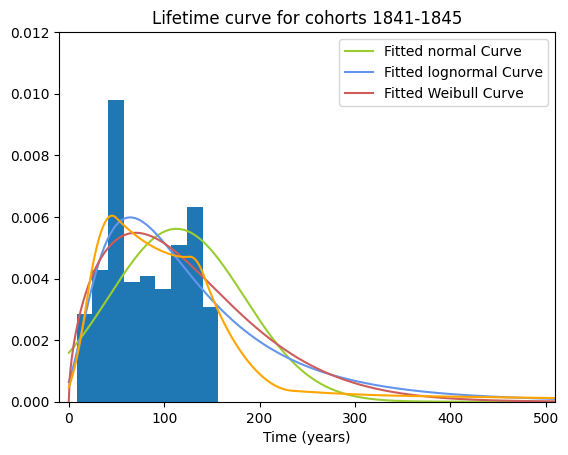

In [39]:
# Plotting the histogram to visualize beneath the lifetime curve. I have to keep it normalized, but take away the still standing bar
df_full = df_full.fillna(0)
tot = len(df_1841_1845)
a, bins_d = np.histogram(df_1841_1845['Age_at_demolition'])
h_histo = a/(tot*np.diff(bins_d)) # HEIGHT OF THE FIRST BAR THAT I WANT TO TAKE OUT
# getting rid of the "still standing buildings" bar
h_histo[0]=0

#plot histogram of data (age at demolition)
plt.bar(bins_d[:-1],height=h_histo,width=np.diff(bins_d), color ='cornflowerblue')

"""---------------------------------------------------------------------------------"""
print("Average lifetime with lognorm distrib is",lognorm.mean(*p_logn))
print( "Average lifetime with normal distrib is ", norm.mean(*p_norm))

# plot lifetimes with all distributions 
plt.plot(x_range,lifetime_norm(x_range, *p_norm),'yellowgreen', label='Fitted normal Curve')
plt.plot(x_range,lifetime_lognorm(x_range, *p_logn),'cornflowerblue', label='Fitted lognormal Curve')
plt.plot(x_range,lifetime_weibull(x_range, *p_weib), 'indianred', label='Fitted Weibull Curve')
plt.plot(x_range[:1000000],lifetime_distribution_derivative[10000:],'orange')
plt.xlabel('Time (years)')
plt.title('Lifetime curve for cohorts 1841-1845')
plt.legend()
plt.xlim(-10,510)
plt.ylim(0,0.012)


plt.bar(bins_d[:-1],height=h_histo,width=np.diff(bins_d))
plt.show()


In [162]:
integrand = lifetime_distribution_derivative[:len(x_range)] # Use the survival curve for each iteration: IT HAS TO REACH ZERO
res = integrate.trapz(integrand, x_range)
print(res)

0.9999594962133296


## Extract back to csv to use on ArcGIS (LEAVE AS COMMENTED)

In [ ]:
"""# specify the output file path
out_file = r"C:\Users\zoec\OneDrive - NTNU\Thesis_NTNU\Datafram_tables\results\result_file_Midtbyen.csv"

# write the dataframe to a csv file
df_full.to_csv(out_file, index=False,sep=';')"""

## Monte Carlo simulation

In [49]:
p_weib

array([0.00724722, 1.55341611])

### Code

In [56]:
# creating the Monte Carlo dataframe (a copy of the necessary parameters of the full df)
df_MC = df_full[['Construction_min','Construction_max','C_lognorm','Demolition_min','Demolition_max','D_unif', 'Is_demolished','Age_at_demolition']].copy()

# keeping only the buildings that can potentially be part of the study cohorts 
df_not_btw_1840_1845 = df_MC[(df_MC['Construction_max']< debut_date) | (df_MC['Construction_min']> end_date)]
df_MC = df_MC.drop(df_not_btw_1840_1845.index)

"""---------------------------------------------------------------------------------"""
x_range = np.linspace(0, 10000, 10001) 

# Set the number of iterations to perform
n_iterations = 10000

# Initialize arrays to store the survival curves for each iteration
survival_curves = np.zeros((n_iterations, len(age_steps) ))
len_selected_df = np.zeros((n_iterations, len(x_range) ))

# for each distribution
#normal
param_fitted_norm_sf = np.zeros((n_iterations, 2 ))
fitted_norm_sf = np.zeros((n_iterations, len(x_range) ))
#lognormal
param_fitted_lognorm_sf = np.zeros((n_iterations, 3 ))
fitted_lognorm_sf = np.zeros((n_iterations, len(x_range) ))
#weibull
param_fitted_weibull_sf = np.zeros((n_iterations, 2 ))
fitted_weibull_sf = np.zeros((n_iterations, len(x_range) ))

# Perform the Monte Carlo simulation
for i in range(n_iterations):

    # Attribute uniform construction dates to the survivor (still standing) buildings
    stding_df = attribute_c_unif(df_MC)

    # Fit a lognormal curve to the histogram of cohorts of the survivor buildings
    par_logn_stg = fit_cohort(stding_df)

    # attribute a construction date according to this lognormal distribution
    attribute_c_lognorm(df_MC,par_logn_stg)

    #attribute a demolition date randomly between D_min and D_max
    attribute_d_unif(df_MC)

    #select the cohorts of study debut -> end date
    df_selected_cohort = selected_cohorts(df_MC, debut_date, end_date)

    # assume that they were all built at the same time (1843)
    df_selected_cohort = df_selected_cohort.assign(C_lognorm = assumed_cohort)

    # make a df of demolished buildings that are part of the selected cohort
    dem_df = df_selected_cohort[(df_selected_cohort['Is_demolished'] == True)]

    # compute the failure time (age at demolition) of the buildings in the selected cohorts
    failure_time(dem_df,df_selected_cohort)
    len_selected_df[i,:] = len(df_selected_cohort)
    
    # Calculate the survival curve for this iteration and store it
    survival_curves[i, :] = survival_curve(age_steps, df_selected_cohort)
    
    # fit it with a normal distribution
    param_fitted_norm_sf[i,:] = fit_surv_fct(norm_sf, age_steps, survival_curves[i, :])
    fitted_norm_sf[i, :] =  norm_sf(x_range, *param_fitted_norm_sf[i,:])

    # fit it with a lognormal distribution
    param_fitted_lognorm_sf[i,:] = fit_surv_fct(lognorm_sf, age_steps, survival_curves[i, :])
    fitted_lognorm_sf[i, :] =  lognorm_sf(x_range, *param_fitted_lognorm_sf[i,:])

    # fit it with a weibull distribution
    param_fitted_weibull_sf[i,:] = fit_surv_fct(weibull, age_steps, survival_curves[i, :])
    fitted_weibull_sf[i, :] =  weibull(x_range, *param_fitted_weibull_sf[i,:])

C:\Users\zoec\AppData\Local\Temp\ipykernel_30412\631340517.py:4: RuntimeWarning: divide by zero encountered in power
  return np.exp(-(x*a)**k)
C:\Users\zoec\AppData\Local\Temp\ipykernel_30412\631340517.py:4: RuntimeWarning: invalid value encountered in power
  return np.exp(-(x*a)**k)
C:\Users\zoec\AppData\Local\Temp\ipykernel_30412\631340517.py:4: RuntimeWarning: overflow encountered in power
  return np.exp(-(x*a)**k)
C:\Users\zoec\AppData\Local\Temp\ipykernel_30412\631340517.py:4: RuntimeWarning: divide by zero encountered in power
  return np.exp(-(x*a)**k)
C:\Users\zoec\AppData\Local\Temp\ipykernel_30412\631340517.py:4: RuntimeWarning: invalid value encountered in power
  return np.exp(-(x*a)**k)
C:\Users\zoec\AppData\Local\Temp\ipykernel_30412\631340517.py:4: RuntimeWarning: overflow encountered in power
  return np.exp(-(x*a)**k)
C:\Users\zoec\AppData\Local\Temp\ipykernel_30412\631340517.py:4: RuntimeWarning: divide by zero encountered in power
  return np.exp(-(x*a)**k)
C:\Use

In [97]:
for i in range(n_iterations):
    fitted_weibull_sf[i, :] =  weibull(x_range, *param_fitted_weibull_sf[i,:])

### Plot

#### Survival function

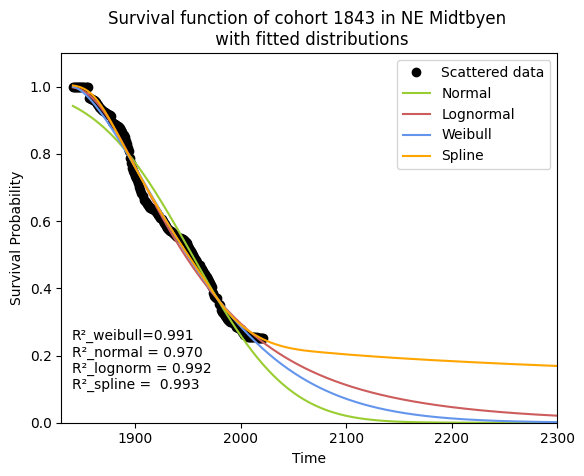

In [113]:
# Calculate the mean and standard deviation of the survival curves
mean_survival_curve = np.mean(survival_curves, axis=0)
std_survival_curve = np.std(survival_curves, axis=0)

# Plot the mean survival curve and its standard deviation
plt.plot(x+ debut_date, mean_survival_curve, 'ko', label='Scattered data')
#plt.fill_between(x + debut_date, mean_survival_curve - 2 * std_survival_curve,
#                 mean_survival_curve + 2 * std_survival_curve, alpha=0.2, color='black', label='95% CI')

# Calculate the mean and standard deviation of the survival curves
mean_param_norm_sf = np.mean(param_fitted_norm_sf, axis=0)
std_norm_sf = np.std(fitted_norm_sf, axis=0)

mean_param_lognorm_sf = np.mean(param_fitted_lognorm_sf, axis=0)
std_lognorm_sf = np.std(fitted_lognorm_sf, axis=0)

mean_param_weibull_sf = np.mean(param_fitted_weibull_sf, axis=0)
std_weibull_sf = np.std(fitted_weibull_sf, axis=0)

# Plot the mean survival curve and its standard deviation
plt.plot(x_range + debut_date, norm_sf(x_range,*mean_param_norm_sf), color='yellowgreen', label='Normal')
plt.plot(x_range + debut_date, lognorm_sf(x_range,*mean_param_lognorm_sf), color='indianred', label='Lognormal')
plt.plot(x_range + debut_date, weibull(x_range,*mean_param_weibull_sf), color='cornflowerblue', label='Weibull')
plt.plot(x_range+debut_date, spline(x_range),'orange',label='Spline')
#plt.fill_between(x_range + debut_date, mean_survival_curve - 2 * std_survival_curve,
#                 mean_survival_curve + 2 * std_survival_curve, alpha=0.2, color='blue', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival function of cohort 1843 in NE Midtbyen \n with fitted distributions')
plt.legend()
plt.ylim(0,1.1)
plt.xlim(1830,2300)

r_lognorm = calculate_r_squared(y,lognorm_sf(x,*mean_param_lognorm_sf))
r_norm = calculate_r_squared(y,norm_sf(x,*mean_param_norm_sf))
r_weibull = calculate_r_squared(y,weibull(x,*mean_param_weibull_sf))

plt.annotate('R²_weibull=%.3f\nR²_normal = %.3f\nR²_lognorm = %.3f\nR²_spline =  %.3f' %(r_weibull,r_norm,r_lognorm,r_frank), (1840, 0.1))

plt.show()

In [108]:
mean_param_norm_sf = np.mean(param_fitted_norm_sf, axis=0)
mean_param_norm_sf = np.append(mean_param_norm_sf, 0)
print(mean_param_norm_sf)

mean_param_lognorm_sf = np.mean(param_fitted_lognorm_sf, axis=0)
print(mean_param_lognorm_sf)

mean_param_weibull_sf = np.mean(param_fitted_weibull_sf, axis=0)
mean_param_weibull_sf = np.append(mean_param_weibull_sf, 0)
print(mean_param_weibull_sf)


[112.88445906  71.54390245   0.        ]
[  0.66023642 -18.67896266 124.55098688]
[0.00727911 1.53270259 0.        ]


In [107]:
"""# Create a DataFrame
df = pd.DataFrame({
    'Mean_Param_Norm_SF': mean_param_norm_sf,
    'Mean_Param_LogNorm_SF': mean_param_lognorm_sf,
    'Mean_Param_Weibull_SF': mean_param_weibull_sf
})

# Export to Excel
df.to_excel('mean_parameters.xlsx',sheet_name='NE Midtbyen' ,index=False)"""

In [101]:
from scipy.stats import weibull_min

avg = weibull_min.mean(*mean_param_weibull_sf)
print(avg)
std_norm_sf = np.std(fitted_norm_sf, axis=0)

"""
from scipy.special import gamma
def weibull_mean(a, k):
    # Calculate the mean using the formula: mean = a * gamma(1 + 1/k)
    mean = a * gamma(1 + 1/k)
    return mean

resu = weibull_mean(*mean_param_weibull_sf)
print(resu)
"""

nan


'\nfrom scipy.special import gamma\ndef weibull_mean(a, k):\n    # Calculate the mean using the formula: mean = a * gamma(1 + 1/k)\n    mean = a * gamma(1 + 1/k)\n    return mean\n\nresu = weibull_mean(*mean_param_weibull_sf)\nprint(resu)\n'

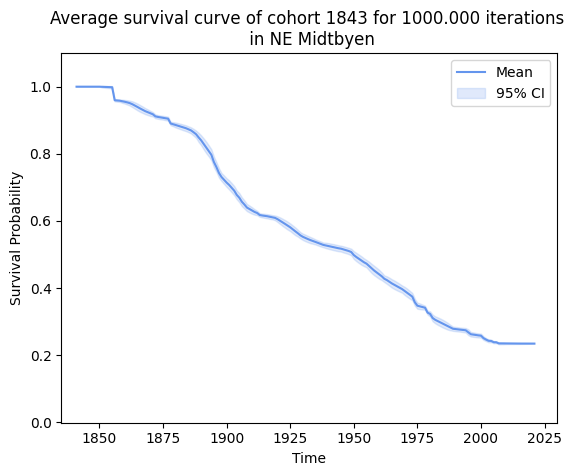

In [ ]:
# Calculate the mean and standard deviation of the survival curves
mean_survival_curve = np.mean(survival_curves, axis=0)
std_survival_curve = np.std(survival_curves, axis=0)

# Plot the mean survival curve and its standard deviation
plt.plot(x+ debut_date, mean_survival_curve, color='cornflowerblue', label='Mean')
plt.fill_between(x + debut_date, mean_survival_curve - 2 * std_survival_curve,
                 mean_survival_curve + 2 * std_survival_curve, alpha=0.2, color='cornflowerblue', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Average survival curve of cohort 1843 for %.3f iterations \n in NE Midtbyen' %(n_iterations))
plt.legend()
plt.ylim(0,1.1)
plt.xlim(1830,2030)
plt.xlim(1835,2030)
plt.ylim(-0.001,1.1)


plt.show()
# for cohorts 1841-1845 = estimated as cohort 1843
  

#### Lifetime distribution

In [103]:
# compute the lifetime from the survival function (using the tail formula)
lifetime_values = np.zeros(n_iterations)

for i in range(n_iterations):
    integrand = fitted_norm_sf[i, :]  # Use the survival curve for each iteration: IT HAS TO REACH ZERO
    lifetime_values[i] = integrate.trapz(integrand, x_range)

# Compute the mean, std deviation and confidence interval of the lifetime
mean_lifetime_distrib= np.mean(lifetime_values)
std_lifetime = np.std(lifetime_values)
confidence_interval_lifetime = np.percentile(lifetime_values, [2.5, 97.5])

# print the results
print("Average Lifetime:", mean_lifetime_distrib)
print("Standard Deviation:", std_lifetime)
print("Confidence Interval (95%):", confidence_interval_lifetime)
print(fitted_weibull_sf[1])

Average Lifetime: 114.6364555990705
Standard Deviation: 0.29062508894839506
Confidence Interval (95%): [114.09074275 115.22030258]
[1.00000000e+000 9.99464557e-001 9.98453492e-001 ... 6.27335661e-310
 5.62538411e-310 5.04431124e-310]


In [ ]:
# plotting the std deviation (idk how useful)
#plt.scatter(x_range,std_survival_curve)

## Hazard rate 

### With the stock definition
h(t) = -(stock (t+ dt) - stock(t))/stock(t)*dt

#### Function

In [114]:
# computing the stock of buildings per year (all cohorts ?)

def stock_per_time(df, time):
    stock_per_year = np.zeros(len(time))
    for i in range(len(time)):
        n_alive = np.sum(df['Is_demolished']==False)
        stock_per_year[i] = n_alive + np.sum((df['D_unif'] >= time[i] + debut_date))
    return stock_per_year

"""----------------------------------------------------------------------------------------"""

# calculating hazard rate rolling average over n_rollingavg

def fct_hazard_rate( time, stock_per_year, n_rollingavg):
    hazard_rate = np.zeros(len(time))
    dt = time[1] - time[0]
    
    for i in range(0,len(time)-1):
        #hazard_rate[t] = (stock_per_year[t-1]-stock_per_year[t])/stock_per_year[t-1]
        hazard_rate[i] = -(stock_per_year[i + 1]-stock_per_year[i])/(stock_per_year[i]*dt)
    
    hr_mvgavg = pd.Series(hazard_rate).rolling(window=n_rollingavg).mean().iloc[n_rollingavg-1:].values
    return hr_mvgavg

"""----------------------------------------------------------------------------------------"""
# doing it all in one function so that it is easier later

def fct_hr_all(n,df,t_steps):
    # calculating hazard rate
    #first the stock
    stock_per_year = stock_per_time(df, t_steps)
    # then hazard rate calculating rolling avg over n
    return fct_hazard_rate( t_steps, stock_per_year, n)

#### Code

In [115]:
# calculate hazard rate regardless of the cause of demolition, FOR THE STUDY COHORT
# rolling avg over n years (centered)
n = 10
hazard_rate = fct_hr_all(n, df_1841_1845, age_steps)

#### Plot

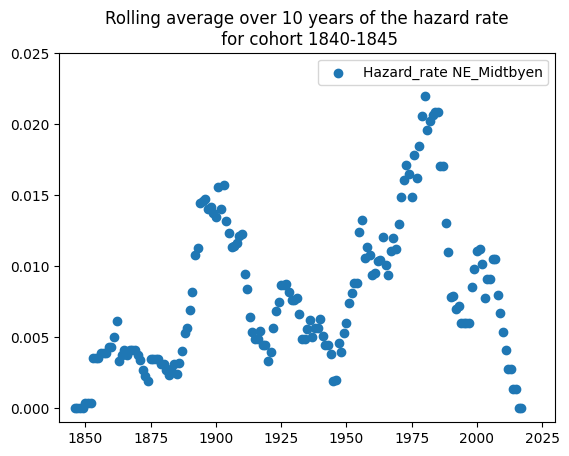

In [116]:
# plot rolling avg of the hr for the selected cohorts

plt.title('Rolling average over 10 years of the hazard rate\n for cohort 1840-1845')
len_ma = len(hazard_rate)
steps_ma = np.arange(0,len_ma)
plt.scatter(steps_ma+debut_date+n/2,hazard_rate) 
plt.xlim(1840,2030)
plt.ylim(-0.001,0.025)
labels=['Hazard_rate NE_Midtbyen']
plt.legend(labels=labels)

### With h(t) = L(t)/S(t)

#### Functions

In [117]:
# for each distribution

def hr_weibull(x,a,k):
    return lifetime_weibull(x,a,k)/weibull(x,a,k)

def hr_norm(x, loc, scale):
    return norm.pdf(x, loc, scale)/norm.sf(x,loc,scale)

def hr_lognorm(x, s, loc, scale):
    return lognorm.pdf(x, s, loc, scale)/lognorm.sf(x,s,loc,scale)

#### Plot (both methods)

In [119]:
#hr for frankenstein
# Calculate the differences between consecutive survival probabilities
diff_survival_probabilities = np.diff(spline(x_range))

# Calculate the derivative of the lifetime distribution
lifetime_distribution_derivative = -diff_survival_probabilities / np.diff(x_range)

#plt.plot(x_range[:len(x_range)-1],lifetime_distribution_derivative)
#plt.xlim(0,2300)
#plt.ylim(0,0.007)

hr_frank = lifetime_distribution_derivative/spline(x_range[0:len(x_range)-1])


R² weibull = 0.18333558291021856
R² normal = -0.3442909185032972
R² lognormal = 0.249820351330594
R² frank = 0.4239596508882326


C:\Users\zoec\AppData\Local\Temp\ipykernel_30412\3760449622.py:4: RuntimeWarning: invalid value encountered in divide
  return lifetime_weibull(x,a,k)/weibull(x,a,k)
C:\Users\zoec\AppData\Local\Temp\ipykernel_30412\3760449622.py:7: RuntimeWarning: divide by zero encountered in divide
  return norm.pdf(x, loc, scale)/norm.sf(x,loc,scale)
C:\Users\zoec\AppData\Local\Temp\ipykernel_30412\3760449622.py:7: RuntimeWarning: invalid value encountered in divide
  return norm.pdf(x, loc, scale)/norm.sf(x,loc,scale)


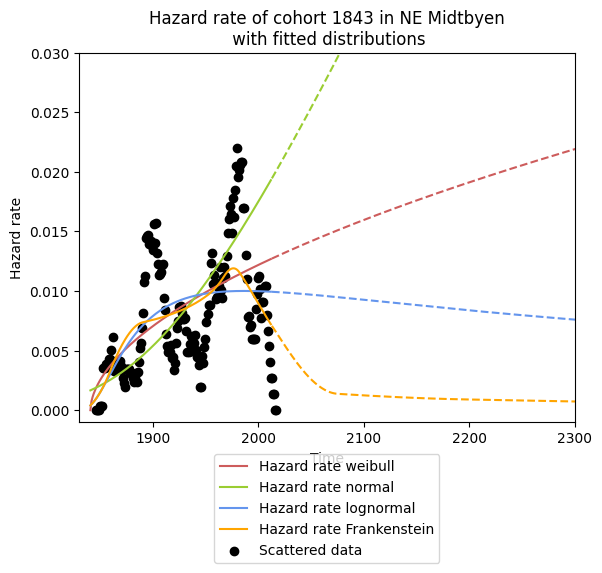

In [120]:
plt.title('Hazard rate of cohort 1843 in NE Midtbyen\n with fitted distributions')

# Plot fitted data with solid lines
plt.plot(x_range[:len(steps_ma)] + debut_date, hr_weibull(x_range[:len(steps_ma)], *p_weib), color='indianred', label='Hazard rate weibull', linestyle='-')
plt.plot(x_range[:len(steps_ma)] + debut_date, hr_norm(x_range[:len(steps_ma)], *p_norm), color='yellowgreen', label='Hazard rate normal', linestyle='-')
plt.plot(x_range[:len(steps_ma)] + debut_date, hr_lognorm(x_range[:len(steps_ma)], *p_logn), color='cornflowerblue', label='Hazard rate lognormal', linestyle='-')
plt.plot(x_range[:len(steps_ma)] + debut_date, hr_frank[:len(steps_ma)], color='orange', label='Hazard rate Frankenstein', linestyle='-')

# Plot scattered data
plt.scatter(steps_ma + debut_date + n/2, hazard_rate, color='k', label='Scattered data')

# Calculate R-squared values
r_hr_weibull = calculate_r_squared(hazard_rate, hr_weibull(steps_ma, *p_weib))
r_hr_norm = calculate_r_squared(hazard_rate, hr_norm(steps_ma, *p_norm))
r_hr_lognorm = calculate_r_squared(hazard_rate, hr_lognorm(steps_ma, *p_logn))
r_hr_frank = calculate_r_squared(hazard_rate, hr_frank[:len(steps_ma)])

# Set plot limits, labels, and legend
plt.xlim(1830, 2300)
plt.ylim(-0.001, 0.03)
plt.xlabel('Time')
plt.ylabel('Hazard rate')

# Print R-squared values
print("R² weibull =", r_hr_weibull)
print("R² normal =", r_hr_norm)
print("R² lognormal =", r_hr_lognorm)
print("R² frank =", r_hr_frank)

# Add legend
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4))

# Plot extrapolated data with dashed lines
# Assuming x_range goes beyond the available data
plt.plot(x_range[len(steps_ma):] + debut_date, hr_weibull(x_range[len(steps_ma):], *p_weib), color='indianred', linestyle='--')
plt.plot(x_range[len(steps_ma):] + debut_date, hr_norm(x_range[len(steps_ma):], *p_norm), color='yellowgreen', linestyle='--')
plt.plot(x_range[len(steps_ma):] + debut_date, hr_lognorm(x_range[len(steps_ma):], *p_logn), color='cornflowerblue', linestyle='--')
plt.plot(x_range[len(steps_ma):len(x_range) - 1] + debut_date, hr_frank[len(steps_ma):len(x_range)], color='orange', linestyle='dashed')

plt.show()


R² weibull = 0.18333558291021856
R² normal = -0.3442909185032972
R² lognormal = 0.249820351330594
R² frank = 0.4239596508882326


C:\Users\zoec\AppData\Local\Temp\ipykernel_30412\3760449622.py:4: RuntimeWarning: invalid value encountered in divide
  return lifetime_weibull(x,a,k)/weibull(x,a,k)
C:\Users\zoec\AppData\Local\Temp\ipykernel_30412\3760449622.py:7: RuntimeWarning: divide by zero encountered in divide
  return norm.pdf(x, loc, scale)/norm.sf(x,loc,scale)
C:\Users\zoec\AppData\Local\Temp\ipykernel_30412\3760449622.py:7: RuntimeWarning: invalid value encountered in divide
  return norm.pdf(x, loc, scale)/norm.sf(x,loc,scale)


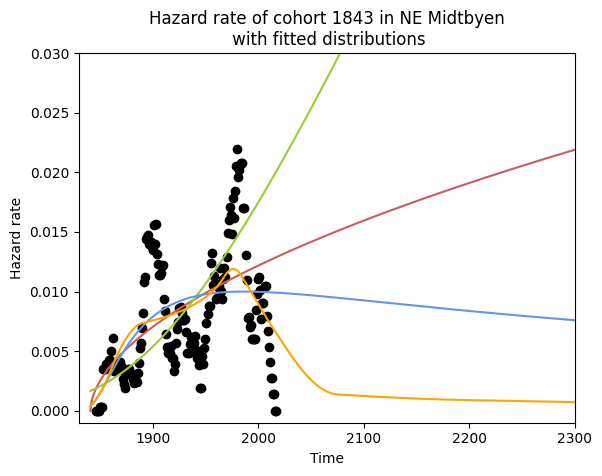

In [124]:
#plot it with the two different methods

plt.title('Hazard rate of cohort 1843 in NE Midtbyen\n with fitted distributions')

plt.plot(x_range + debut_date, hr_weibull(x_range, *p_weib), color='indianred')
plt.plot(x_range + debut_date  , hr_norm(x_range, *p_norm), color='yellowgreen')
plt.plot(x_range + debut_date  , hr_lognorm(x_range,*p_logn), color='cornflowerblue')
plt.plot(x_range[:len(x_range)-1] + debut_date  , hr_frank[:len(x_range)], color='orange')
plt.scatter(steps_ma + debut_date+n/2,hazard_rate, color='k')

r_hr_weibull = calculate_r_squared(hazard_rate, hr_weibull(steps_ma, *p_weib))
r_hr_norm = calculate_r_squared(hazard_rate, hr_norm(steps_ma, *p_norm))
r_hr_lognorm = calculate_r_squared(hazard_rate, hr_lognorm(steps_ma, *p_logn))
#r_hr_frank = calculate_r_squared(hazard_rate,hr_frank[:len(steps_ma)])

plt.xlim(1830,2300)
plt.ylim(-0.001,0.03)
plt.xlabel('Time')
plt.ylabel('Hazard rate')

print("R² weibull =",r_hr_weibull)
print("R² normal =",r_hr_norm)
print("R² lognormal =",r_hr_lognorm)
print("R² frank =",r_hr_frank)
#plt.legend(['Hazard rate calculated with weibull distribution','Hazard rate calculated with normal distribution','Hazard rate calculated with lognormal distribution', 'Hazard rate Frankenstein', 'Scattered data'],  loc = 'lower center', bbox_to_anchor=(0.5, -0.4))

In [ ]:
# creating the Monte Carlo dataframe (a copy of the necessary parameters of the full df)
df_MC_scenario = df_full[['Construction_min','Construction_max','C_lognorm','Demolition_min','Demolition_max','D_unif', 'Is_demolished','Age_at_demolition']].copy()

# keeping only the buildings that can potentially be part of the study cohorts 
df_not_btw_1840_1845 = df_MC_scenario[(df_MC_scenario['Construction_max']< debut_date) | (df_MC_scenario['Construction_min']> end_date)]
df_MC_scenario = df_MC_scenario.drop(df_not_btw_1840_1845.index)

"""---------------------------------------------------------------------------------"""

# Set the number of iterations to perform
n_iterations = 1000

n_avg = 10 # for the rolling avrg

# Initialize arrays to store the survival curves for each iteration
hazard_rates = np.zeros((n_iterations, len(steps_ma)))


# Perform the Monte Carlo simulation
for i in range(n_iterations):
    attribute_dem_for_nodata(df_MC_scenario, map_date, present_date)
    # Attribute uniform construction dates to the survivor (still standing) buildings
    stding_df = attribute_c_unif(df_MC_scenario)

    # Fit a weibull curve to the histogram of cohorts of the survivor buildings
    par_logn_stg = fit_cohort(stding_df)

    # attribute a construction date according to this weibull distribution
    attribute_c_lognorm(df_MC_scenario,par_logn_stg)

    #attribute a demolition date randomly between D_min and D_max
    attribute_d_unif(df_MC_scenario)

    #select the cohorts of study debut -> end date
    df_selected_cohort = selected_cohorts(df_MC_scenario, debut_date, end_date)

    # assume that they were all built at the same time (1843)
    df_selected_cohort = df_selected_cohort.assign(C_lognorm = assumed_cohort)

    # Calculate the hazard rate for this iteration and store it (the current one)
    hazard_rates[i,:] = fct_hr_all(n,df_selected_cohort,age_steps)

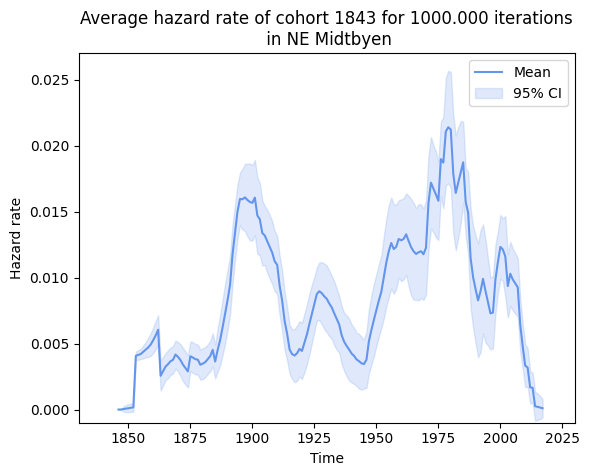

In [ ]:
# Calculate the mean and standard deviation of the survival curves
mean_hr = np.mean(hazard_rates, axis=0)
std_hr= np.std(hazard_rates, axis=0)

# Plot the mean survival curve and its standard deviation
plt.plot(steps_ma + debut_date+n/2, mean_hr, color='cornflowerblue', label='Mean')
plt.fill_between(steps_ma+ debut_date+n/2, mean_hr - 2 * std_hr,
                 mean_hr + 2 * std_hr, alpha=0.2, color='cornflowerblue', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Hazard rate')
plt.title('Average hazard rate of cohort 1843 for %.3f iterations\n in NE Midtbyen' %(n_iterations))
plt.legend()

plt.xlim(1830,2030)
plt.ylim(-0.001,0.027)
plt.show()

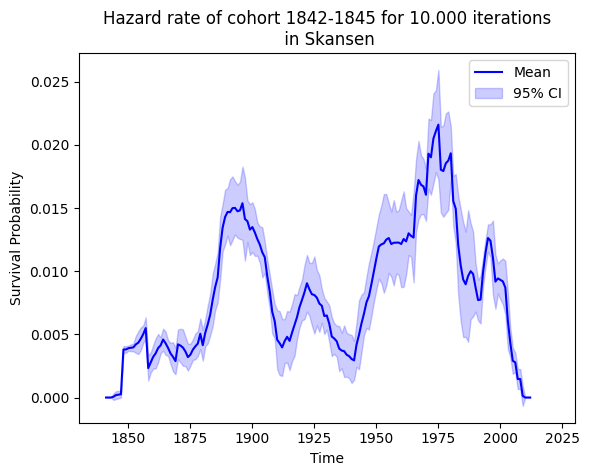

In [ ]:
# Calculate the mean and standard deviation of the survival curves
mean_hr = np.mean(hazard_rates, axis=0)
std_hr= np.std(hazard_rates, axis=0)

# Plot the mean survival curve and its standard deviation
plt.plot(steps_ma + debut_date, mean_hr, color='blue', label='Mean')
plt.fill_between(steps_ma+ debut_date, mean_hr - 2 * std_hr,
                 mean_hr + 2 * std_hr, alpha=0.2, color='blue', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Hazard rate of cohort 1842-1845 for %.3f iterations\n in Skansen' %(n_iterations))
plt.legend()

plt.xlim(1830,2030)
plt.show()

### Stock

In [ ]:
# creating the Monte Carlo dataframe (a copy of the necessary parameters of the full df)
df_MC_stock = df_full[['Construction_min','Construction_max','C_lognorm','Demolition_min','Demolition_max','D_unif', 'Is_demolished','Age_at_demolition']].copy()

# keeping only the buildings that can potentially be part of the study cohorts 
df_not_btw_1840_1845 = df_MC_stock[(df_MC_stock['Construction_max']< debut_date) | (df_MC_stock['Construction_min']> end_date)]
df_MC_stock = df_MC_stock.drop(df_not_btw_1840_1845.index)

"""---------------------------------------------------------------------------------"""

# Set the number of iterations to perform
n_iterations = 10
stocks = np.zeros((n_iterations,len(age_steps)))

# Perform the Monte Carlo simulation
for i in range(n_iterations):
    attribute_dem_for_nodata(df_MC_scenario, map_date, present_date)
    # Attribute uniform construction dates to the survivor (still standing) buildings
    stding_df = attribute_c_unif(df_MC_scenario)

    # Fit a weibull curve to the histogram of cohorts of the survivor buildings
    par_logn_stg = fit_cohort(stding_df)

    # attribute a construction date according to this weibull distribution
    attribute_c_lognorm(df_MC_scenario,par_logn_stg)

    #attribute a demolition date randomly between D_min and D_max
    attribute_d_unif(df_MC_scenario)

    #select the cohorts of study debut -> end date
    df_selected_cohort = selected_cohorts(df_MC_scenario, debut_date, end_date)

    # assume that they were all built at the same time (1843)
    df_selected_cohort = df_selected_cohort.assign(C_lognorm = assumed_cohort)

    # Calculate the stock for this iteration and store it (the current one)
    stocks[i,:] = stock_per_time(df_selected_cohort,age_steps)
   

[311.  311.  311.  311.  311.  311.  311.  311.  311.  311.  311.  311.
 310.8 310.8 310.8 310.8 310.5 299.5 299.5 299.3 298.8 298.1 297.5 296.4
 294.8 293.6 292.8 291.4 290.1 288.5 287.8 286.9 286.2 284.6 284.1 283.5
 283.3 282.6 282.2 276.7 276.1 275.5 274.4 273.5 272.7 272.1 271.6 270.6
 269.1 266.9 264.2 261.8 257.5 253.4 250.5 247.3 240.6 236.  231.7 228.2
 226.2 224.5 221.8 219.5 217.1 212.3 209.8 205.2 203.  199.4 197.8 196.3
 195.1 194.7 193.3 192.9 192.6 192.5 192.  191.6 190.9 189.9 188.  186.6
 184.5 183.2 181.4 179.2 177.6 176.1 174.7 172.8 171.6 170.7 169.7 169.2
 168.4 167.1 166.8 165.9 165.4 164.8 164.6 164.2 163.3 162.5 162.2 161.3
 160.4 159.7 159.  156.8 154.6 153.7 152.1 150.7 149.5 147.2 145.1 143.4
 141.4 140.1 137.9 135.5 134.2 132.3 130.7 128.8 128.1 127.  125.1 123.2
 121.6 119.5 117.7 112.7 110.1 109.2 108.6 108.5 103.2 101.8  98.1  96.4
  95.4  94.2  92.8  91.   90.6  89.2  87.7  87.1  87.   86.8  86.4  86.1
  84.4  82.5  82.3  81.9  81.5  81.4  79.2  78.   76

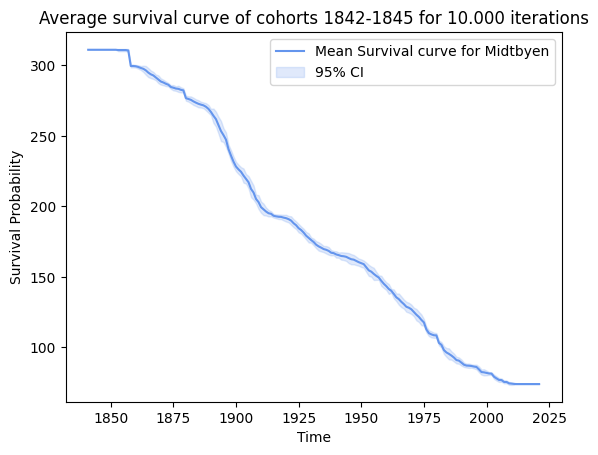

In [ ]:
# Calculate the mean and standard deviation of the survival curves

mean_stock = np.mean(stocks,axis=0)
print(mean_stock)
std_stock = np.std(stocks,axis=0)

# Plot the mean survival curve and its standard deviation
#plt.scatter(x+debut_date,y)
plt.plot(x+ debut_date, mean_stock, color='cornflowerblue', label='Mean Survival curve for Midtbyen')

plt.fill_between(x + debut_date, mean_stock - 2 * std_stock,
                 mean_stock + 2 * std_stock, alpha=0.2, color='cornflowerblue', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Average survival curve of cohorts 1842-1845 for %.3f iterations' %(n_iterations))
plt.legend( )

plt.show()
plt.show()

[311.0, 299.3, 288.5, 276.7, 266.9, 228.2, 199.4, 191.6, 176.1, 165.9, 159.7, 143.4, 127.0, 108.5, 89.2, 81.9, 74.3, 74.0, 74.0]


(-1.0, 18.0)

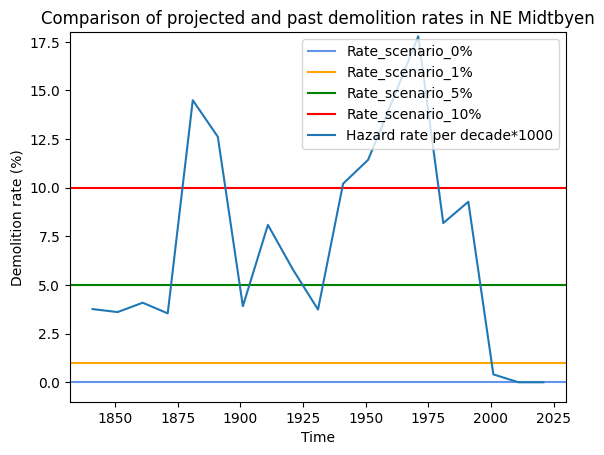

In [ ]:

def get_building_stock_every_ten_years(building_stock):
    building_stock_every_ten_years = []
    for i in range(0, len(building_stock), 10):
        start_year = i
        end_year = min(i + 9, len(building_stock) - 1)
        building_stock_every_ten_years.append(building_stock[end_year])
    return building_stock_every_ten_years

time = np.arange(debut_date,present_date,step=10)

mean_stock_decade = get_building_stock_every_ten_years(mean_stock)
print(mean_stock_decade)
plt.axhline(0,color='cornflowerblue',label='Rate_scenario_0%')
plt.axhline(1,color='orange',label='Rate_scenario_1%')
plt.axhline(5,color='green',label='Rate_scenario_5%')
plt.axhline(10,color='red',label='Rate_scenario_10%')
hr_decade = fct_hazard_rate(time,mean_stock_decade,1)
plt.plot(time,hr_decade*1000, label='Hazard rate per decade*1000')
plt.legend()
plt.title('Comparison of projected and past demolition rates in NE Midtbyen')
plt.xlabel('Time')
plt.ylabel('Demolition rate (%)')
plt.ylim(-1,18)

In [ ]:
def calculate_demolition_percentage(building_stock):
    demolition_percentage = []
    for i in range(0, len(building_stock),10):
        start_count = building_stock[i]
        end_count = building_stock[i + 10] if i + 10 < len(building_stock) else building_stock[-1]
        demolished = start_count - end_count
        demolition_percentage.append((demolished / start_count) * 100)
    return demolition_percentage


[0.0, 3.922829581993566, 3.681392235609103, 4.065323141070184, 4.310032596885199, 14.383043149129449, 12.555260831122892, 3.4883720930232585, 8.486118386589846, 5.323411562678869, 3.8694074969770287, 11.069182389937103, 11.527581329561535, 17.505995203836925, 15.01937984496124, 7.0695553021664805, 9.079754601227002, 0.13495276653170624, 0.0]


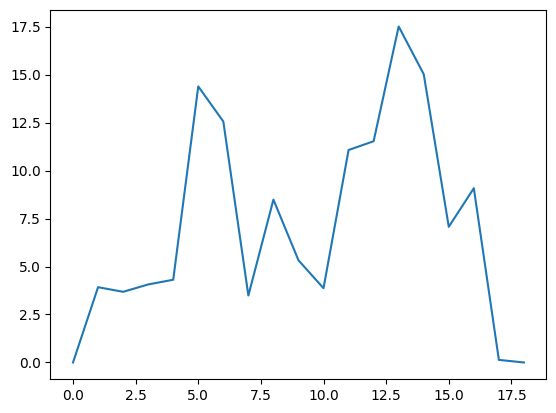

In [ ]:
a = calculate_demolition_percentage(mean_stock)
print(a)
teststt = np.arange(0,len(a))
b = a
plt.plot(teststt,b)

## Fitting the data using the hazard rate

### Smooth the hazard rate

#### Function

In [ ]:
# to smoothe the hazard rate with a splrep BSpline (smoothing Spline)
# s is the ""smooth coefficient"" (the bigger is s, the smoother the fit)
# returns a list of the 'smoothed' hasard rate

def smooth_hr(t,t_2, hr_avg, s):
    tck = splrep(t,hr_avg,s = s)
    res = BSpline(*tck)(t_2)
    return res

"""----------------------------------------------------------------------------------------"""
#cumulative hazard rate: in this case, sum of hazard rate in each point
def cumulative_hr(hr):
    cum_hr = np.zeros(len(hr))
    for i in range(len(hr) - 1):
        cum_hr[i+1] = cum_hr[i] + hr[i+1]
    return cum_hr

#### Code

In [ ]:
# constants
s = 0.00008 #how smooth

x_s = np.arange(0,len(hazard_rate))
#to be able to extrapolate
x_ss = np.arange(0,len(hazard_rate))
y_s = smooth_hr(x_s, x_ss,hazard_rate, s)


#### Plot

Text(1900, 0.019, 'R²_spline= 0.983')

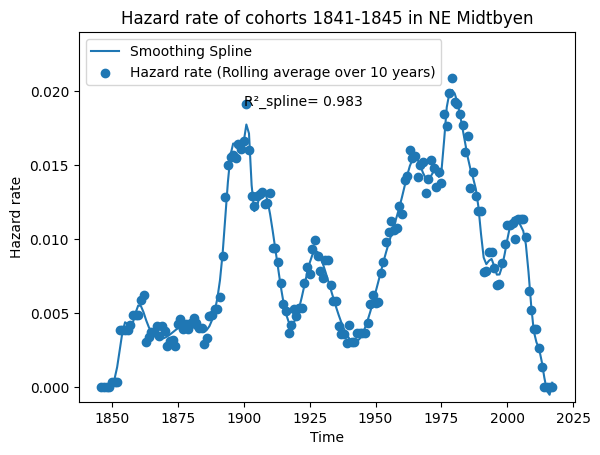

In [ ]:
# plotting the smooth hazard rate

plt.plot(x_s+debut_date+n/2, y_s)
plt.scatter(x_s+debut_date+n/2,hazard_rate)
labels =["Smoothing Spline", "Hazard rate (Rolling average over 10 years)"]
plt.legend(labels = labels)
plt.xlabel("Time")
plt.ylabel('Hazard rate')
plt.ylim(-0.001,0.024)
plt.title('Hazard rate of cohorts 1841-1845 in NE Midtbyen')
r2_hr = calculate_r_squared(hazard_rate,y_s)
plt.annotate('R²_spline= %.3f' %(r2_hr),(1900,0.019))

### Obtaining survival curve and lifetime from it

#### Code

In [ ]:
# cumulative hr
cum_hr = cumulative_hr(y_s)

# survival function = exp(-cum_hr)
survival_fct_hr = np.exp(-cum_hr)


#### Plot

R² spline = 0.9893611271993915


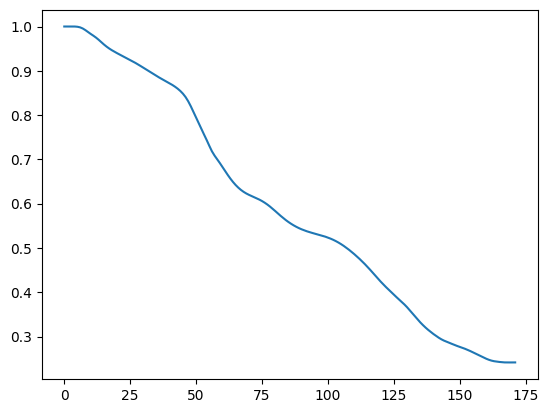

In [ ]:
#plot the survival fct
plt.plot(x_s, survival_fct_hr)

#calculate R²
r_spline = calculate_r_squared(y,survival_fct_hr)
print("R² spline =",r_spline)

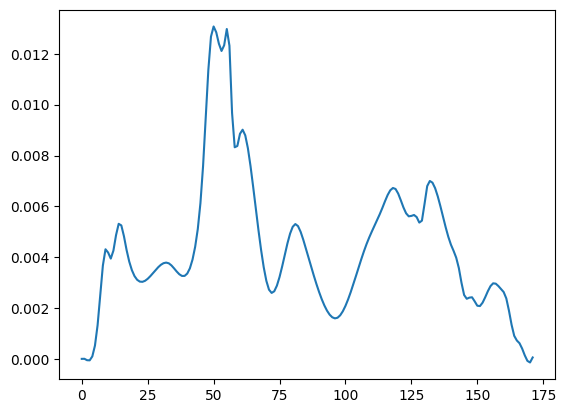

In [ ]:
# now lifetime: L=hr*S

L_hr = y_s*survival_fct_hr
plt.plot(x_s,L_hr)


## Scenarios

### Function

In [ ]:
# generates a building stock for the future where the stock decreases from the initial by decrease percentage at the beginning of each decrease_interval

def generate_building_stock(initial_stock, decrease_percentage, decrease_interval, end_year):
    # decrease_percentage in % of the stock
    
    building_stock = [initial_stock]  # List to store building stock
    current_year = 1  # Starting year

    while current_year <= end_year:
        if current_year % decrease_interval == 0:
            decrease_val = initial_stock * decrease_percentage / 100
            initial_stock = initial_stock - decrease_val
        building_stock.append(initial_stock)
        current_year += 1

    return building_stock

"""-----------------------------------------------------------------------------------------------"""

#calculates the future hazard rate from this future stock (rolling average)
def future_hr(len_future, decrease_percentage, decrease_interval,n_mvgavg):
    present_stock = np.sum(df_1841_1845['Is_demolished']==False)
    end_year = len_future
    building_stock = generate_building_stock(present_stock, decrease_percentage, decrease_interval, end_year)
    future_hazard_rate = np.zeros(len_future)
    dt = 1
    for i in range(0,len_future-1):
        future_hazard_rate[i] = -(building_stock[i + 1]-building_stock[i])/(building_stock[i]*dt)
    
    hr_mvgavg_future = pd.Series(future_hazard_rate).rolling(window=n_mvgavg).mean().iloc[n_mvgavg-1:].values
    return hr_mvgavg_future
    
"""-----------------------------------------------------------------------------------------------"""
# calculates the smooth hr 
def scenario_hr(hr, len_future, decrease_percentage, decrease_interval,n_mvgavg):
    hr_future = future_hr(len_future, decrease_percentage, decrease_interval,n_mvgavg)
    hr_sce = np.zeros(len(hr)+len(hr_future))
    hr_sce[0:len(hr)] = hr
    hr_sce[(len(hr)):len(hr)+len(hr_future)] = hr_future
    #smoothing spline
    s = 0.00008 #how smooth
    x_s = np.arange(0,len(hr_sce))
    y_s = smooth_hr(x_s, x_s,hr_sce, s)
    return(x_s,y_s)

### Code

In [ ]:
#CONSTANTS
# how many years in the future we want to estimate
len_future = 8000
# how many years between demolitions
decrease_interval = 10
# over how many yrs moving average (I think it is better with same value)
n_mvgavg = 10

# scenario 1: no buildings gets dem

decrease_percentage = 0

x_s1,y_s1 = scenario_hr(hazard_rate, len_future, decrease_percentage, decrease_interval,n_mvgavg)

# scenario 2: 1% building stock get dem every 10 yrs

decrease_percentage = 1
x_s2,y_s2 = scenario_hr(hazard_rate, len_future, decrease_percentage, decrease_interval,n_mvgavg)


# scenario 3: 5% of the building get dem every 10 yrs

decrease_percentage = 5

x_s3,y_s3 = scenario_hr(hazard_rate, len_future, decrease_percentage, decrease_interval,n_mvgavg)


# scenario 4: 10% building stock gets dem every 10 yrs

decrease_percentage = 10
x_s4,y_s4 = scenario_hr(hazard_rate, len_future, decrease_percentage, decrease_interval,n_mvgavg)


### Plot

(1830.0, 2900.0)

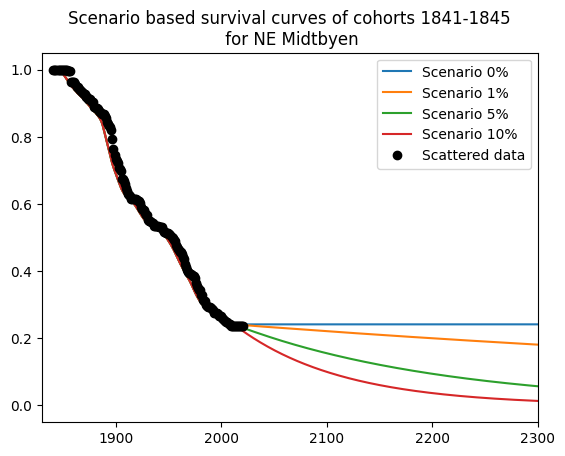

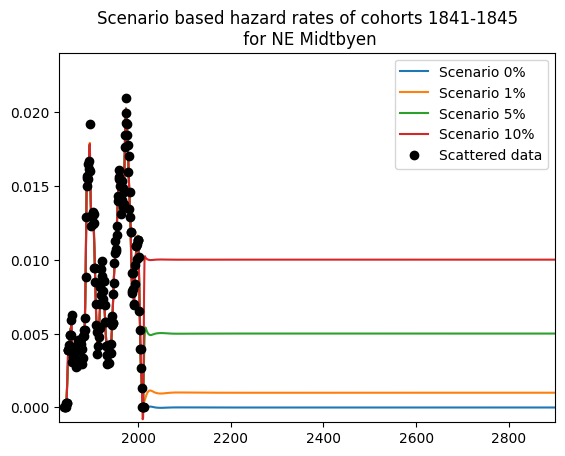

In [ ]:
#plot all scenario

cum_hr_sce_1 = cumulative_hr(y_s1)
cum_hr_sce_2 = cumulative_hr(y_s2)
cum_hr_sce_3 = cumulative_hr(y_s3)
cum_hr_sce_4 = cumulative_hr(y_s4)

survival_sce_1 = np.exp(-cum_hr_sce_1)
survival_sce_2 = np.exp(-cum_hr_sce_2)
survival_sce_3 = np.exp(-cum_hr_sce_3)
survival_sce_4 = np.exp(-cum_hr_sce_4)

plt.plot(x_s1 + debut_date, survival_sce_1)
plt.plot(x_s2 + debut_date, survival_sce_2)
plt.plot(x_s3 + debut_date, survival_sce_3)
#plt.axhline(0.003215434083601286)
plt.plot(x_s4 + debut_date, survival_sce_4)
plt.plot(age_steps+debut_date, y, 'ko', label='Scattered Data')

plt.xlim(1830,2300)

labels =['Scenario 0%', 'Scenario 1%','Scenario 5%','Scenario 10%','Scattered data']
plt.legend(labels = labels)
plt.title('Scenario based survival curves of cohorts 1841-1845\n for NE Midtbyen')

plt.figure()
plt.plot(x_s1 + debut_date, y_s1)
plt.plot(x_s2 + debut_date,  y_s2)
plt.plot(x_s3 + debut_date,  y_s3)
plt.plot(x_s4 + debut_date,  y_s4)
plt.plot(steps_ma+debut_date, hazard_rate, 'ko', label='Scattered Data')
plt.ylim(-0.001,0.024)
labels =['Scenario 0%', 'Scenario 1%','Scenario 5%','Scenario 10%','Scattered data']
plt.legend(labels = labels)
plt.title('Scenario based hazard rates of cohorts 1841-1845\n for NE Midtbyen')
plt.xlim(1830,2900)

In [ ]:
print(len(df_1841_1845))
1/311

311


0.003215434083601286

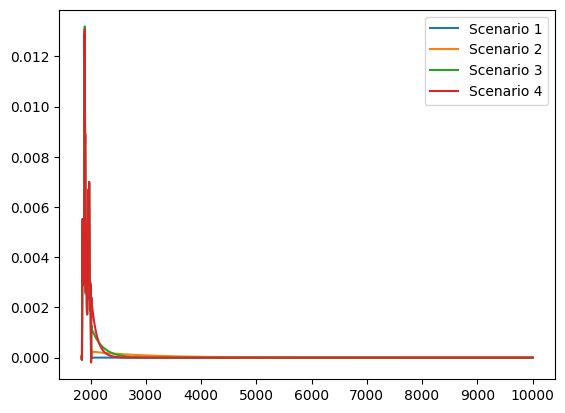

In [ ]:
# lifetime for scenarios
lifetime_sce_1 = y_s1*survival_sce_1
lifetime_sce_2 = y_s2*survival_sce_2
lifetime_sce_3 = y_s3*survival_sce_3
lifetime_sce_4 = y_s4*survival_sce_4

plt.plot(x_s1 + debut_date, lifetime_sce_1)
plt.plot(x_s2 + debut_date, lifetime_sce_2)
plt.plot(x_s3 + debut_date, lifetime_sce_3)
plt.plot(x_s4 + debut_date, lifetime_sce_4)
labels =['Scenario 1', 'Scenario 2','Scenario 3','Scenario 4']
plt.legend(labels = labels)

In [ ]:
from scipy import integrate

# Define the integrand
integrand_1 = survival_sce_1
integrand_2 = survival_sce_2
integrand_3 = survival_sce_3
integrand_4 = survival_sce_4

# Perform numerical integration to calculate the integral
integral_1 = integrate.trapz(integrand_1, x_s1)
integral_2 = integrate.trapz(integrand_2, x_s2)
integral_3 = integrate.trapz(integrand_3, x_s3)
integral_4 = integrate.trapz(integrand_4, x_s4)

print(integral_1,integral_2,integral_3,integral_4)
# lifetimes ! the first one is "infinite" => makes sense, for the others, you have to prolongate the survival fct enough for it to reach 0, and then the numbers barely change
""" source : https://stackoverflow.com/questions/43173044/how-to-compute-the-mean-survival-time"""

2031.7058216800015 343.4237043856529 150.30489468580052 126.14735124472736


' source : https://stackoverflow.com/questions/43173044/how-to-compute-the-mean-survival-time'

## Monte Carlo for scenarios

In [ ]:
# creating the Monte Carlo dataframe (a copy of the necessary parameters of the full df)
df_MC_scenario = df_full[['Construction_min','Construction_max','C_lognorm','Demolition_min','Demolition_max','D_unif', 'Is_demolished','Age_at_demolition']].copy()

# keeping only the buildings that can potentially be part of the study cohorts 
df_not_btw_1840_1845 = df_MC_scenario[(df_MC_scenario['Construction_max']< debut_date) | (df_MC_scenario['Construction_min']> end_date)]
df_MC_scenario = df_MC_scenario.drop(df_not_btw_1840_1845.index)

"""---------------------------------------------------------------------------------"""

# Set the number of iterations to perform
n_iterations = 100

n_avg = 10 # for the rolling avrg
len_future = 2000
decrease_interval = 10
decrease_percentage = 10
if area=='Midtbyen':
    n_mystere = 163
else:
    n_mystere =162
# Initialize arrays to store the survival curves for each iteration
hazard_rates = np.zeros((n_iterations, len_future+n_mystere))
#param_fitted_sf = np.zeros((n_iterations, len(age_steps) ))
#fitted_sf = np.zeros((n_iterations, len(x_range) ))


# Perform the Monte Carlo simulation
for i in range(n_iterations):

    # Attribute uniform construction dates to the survivor (still standing) buildings
    stding_df = attribute_c_unif(df_MC_scenario)

    # Fit a lognormal curve to the histogram of cohorts of the survivor buildings
    par_logn_stg = fit_cohort(stding_df)

    # attribute a construction date according to this lognormal distribution
    attribute_c_lognorm(df_MC_scenario,par_logn_stg)

    #attribute a demolition date randomly between D_min and D_max
    attribute_d_unif(df_MC_scenario)

    #select the cohorts of study debut -> end date
    df_selected_cohort = selected_cohorts(df_MC_scenario, debut_date, end_date)

    # assume that they were all built at the same time (1843)
    df_selected_cohort = df_selected_cohort.assign(C_lognorm = assumed_cohort)

    # Calculate the hazard rate for this iteration and store it (the current one)
    hazard_rate = fct_hr_all(n,df_selected_cohort,age_steps)
    
    # Calculate the future hazard rate
    x,hazard_rates[i,:] = scenario_hr(hazard_rate, len_future, decrease_percentage, decrease_interval,n_mvgavg)
    

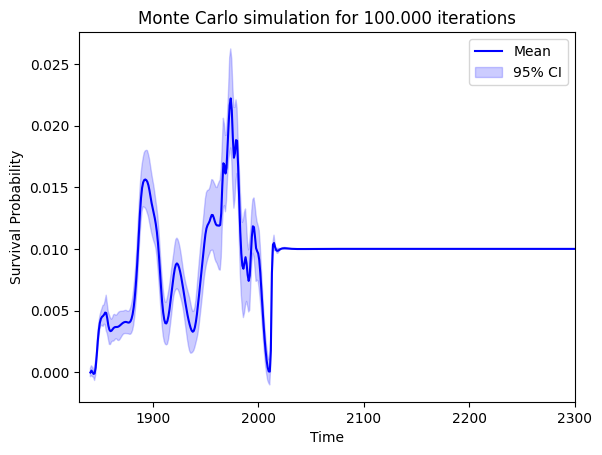

In [ ]:
# Calculate the mean and standard deviation of the survival curves
mean_hr = np.mean(hazard_rates, axis=0)
std_hr= np.std(hazard_rates, axis=0)

# Plot the mean survival curve and its standard deviation
plt.plot(x + debut_date, mean_hr, color='blue', label='Mean')
plt.fill_between(x + debut_date, mean_hr - 2 * std_hr,
                 mean_hr + 2 * std_hr, alpha=0.2, color='blue', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Monte Carlo simulation for %.3f iterations' %(n_iterations))
plt.legend()

plt.xlim(1830,2300)
plt.show()

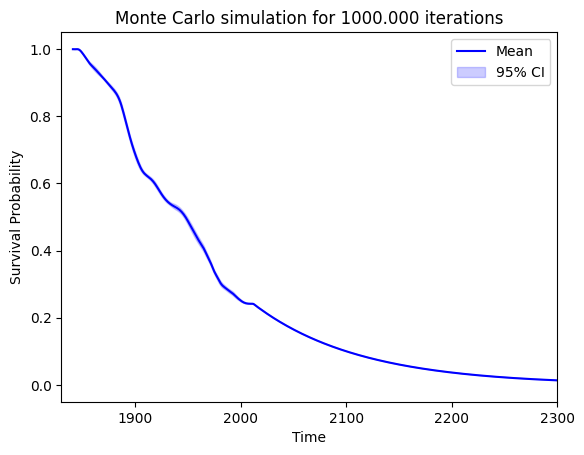

In [ ]:
sf_hr= np.zeros((n_iterations, len_future + n_mystere))
for i in range(n_iterations):
    cum_hr = cumulative_hr(hazard_rates[i,:])
    # survival function = exp(-cum_hr)
    sf_hr[i,:] = np.exp(-cum_hr)

# Calculate the mean and standard deviation of the survival curves
mean_sfhr = np.mean(sf_hr, axis=0)
std_sfhr= np.std(sf_hr, axis=0)

# Plot the mean survival curve and its standard deviation
plt.plot(x + debut_date, mean_sfhr, color='blue', label='Mean')
plt.fill_between(x + debut_date, mean_sfhr - 2 * std_sfhr,
                 mean_sfhr + 2 * std_sfhr, alpha=0.2, color='blue', label='95% CI')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Monte Carlo simulation for %.3f iterations' %(n_iterations*10))
plt.legend()

plt.xlim(1830,2300)
plt.show()

In [ ]:
#avg lifetime
lifetime_values = np.zeros(n_iterations)

for i in range(n_iterations):
    integrand = sf_hr[i, :]  # Use the survival curve for each iteration: IT HAS TO REACH ZERO
    lifetime_values[i] = integrate.trapz(integrand, x)

# Compute the mean, std deviation and confidence interval of the lifetime
mean_lifetime_distrib= np.mean(lifetime_values)
std_lifetime = np.std(lifetime_values)
confidence_interval_lifetime = np.percentile(lifetime_values, [2.5, 97.5])

# print the results
print("Average Lifetime:", mean_lifetime_distrib)
print("Standard Deviation:", std_lifetime)
print("Confidence Interval (95%):", confidence_interval_lifetime)

Average Lifetime: 126.22819667854935
Standard Deviation: 0.19986289588210518
Confidence Interval (95%): [125.88147982 126.67163089]


: 